In [ ]:
import pickle
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#from zipfile import ZipFile
#from google.colab import drive

#drive.mount('/content/gdrive/', force_remount=True)

We first need to get the training and test datasets and form a dataframe that contains both of these datasets. We should also sort the records in the training dataset in chronological order.

In [ ]:
base_path = 'C:/Users/Катя/Downloads/epamdscourseclassification32022/'
#base_path = '/content/gdrive/MyDrive/epamdscourseclassification32022/'

times = ['time%s' % i for i in range(1, 11)]
webpages = ['webpage%s' % i for i in range(1, 11)]

train = pd.read_csv(base_path + 'train.csv', parse_dates = times, index_col='session_id')
test = pd.read_csv(base_path + 'test.csv', parse_dates = times, index_col='session_id')

train.sort_values(by='time1', inplace=True)

idx = train.shape[0]
data = pd.concat([train, test], sort=False) # leave train.target for eda

train.shape, test.shape, data.shape

((159969, 21), (93338, 20), (253307, 21))

Missing values are filled with 0.

In [ ]:
data[webpages] = data[webpages].fillna(0).astype(np.uint16)

The website ids of each row are put into one string separated by a space. `TfidfVectorizer` is used to convert the data to a matrix of TF-IDF features.

In [ ]:
data['words'] = data[webpages].astype(np.str).apply(' '.join, axis=1)

words = TfidfVectorizer(max_features=50000, ngram_range=(1, 3)).fit_transform(data['words'])

data.drop(['words'], inplace=True, axis=1)
words

<253307x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 3441455 stored elements in Compressed Sparse Row format>

Here I create the following features: session duration, year combined with month, day of week and hour.

In [ ]:
data['min'] = data[times].min(axis=1)
data['max'] = data[times].max(axis=1)

data['duration'] = ((data['max'] - data['min']) / np.timedelta64(1, 'm')).round(2)
data.drop(['min','max'], inplace=True, axis=1)

data['yyyymm'] = data['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype(np.int32)

data['dayofweek'] = data['time1'].apply(lambda ts: ts.dayofweek).astype(np.int8)

data['hour'] = data['time1'].apply(lambda ts: ts.hour).astype(np.int8)

I'll use `id_map.parquet` to extract the domain.

In [ ]:
map = pd.read_parquet(base_path + 'id_map.parquet')
map.index = map.id

map['split'] = map['webpage'].str.split('.')
map['domain'] = map['split'].map(lambda x: x[-1])

map.drop(['webpage','split'], inplace=True, axis=1)
map.index.rename('webpage1', inplace=True)
data = pd.merge(data, map, how='left', on='webpage1')

Here we can see the difference between the target user and others. Target user sessions are usually shorter.

(-1.0, 5.0)

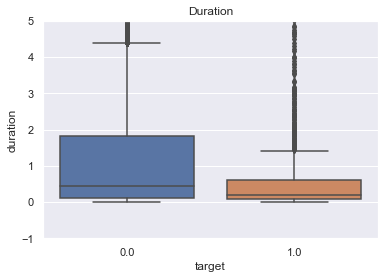

In [ ]:
ax = sns.boxplot(x='target', y='duration', data=data)
ax.set_title('Duration')
ax.set_ylim(-1,5)

The following function is used for creating three countplots for some feature.

In [ ]:
def build_countplot(x):
  _, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,4))
  sns.countplot(x=x, data=data[data.target==1], ax=axes[0]).set_title('Target user')
  sns.countplot(x=x, data=data[data.target==0], ax=axes[1]).set_title('Not target user')
  sns.countplot(x=x, data=data[idx:], ax=axes[2]).set_title('Test')

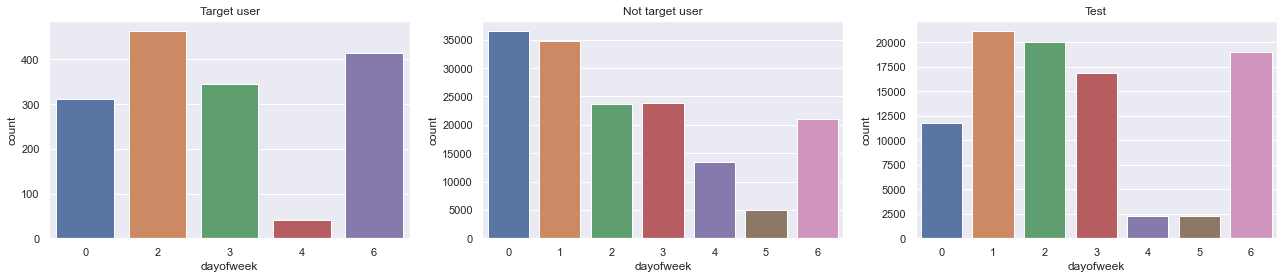

In [ ]:
build_countplot('dayofweek')

We can see that the target user doesn't browse on Tuesdays and Saturdays. Most often he browses on Wednesdays. Let's create new features based on this information.

In [ ]:
data['browse_day'] = data['time1'].apply(lambda ts: ts.dayofweek in [0,2,3,6]).astype(np.int8)
data['tue'] = data['time1'].apply(lambda ts: ts.dayofweek in [1]).astype(np.int8)
data['wed'] = data['time1'].apply(lambda ts: ts.dayofweek in [2]).astype(np.int8)
data['sat'] = data['time1'].apply(lambda ts: ts.dayofweek in [5]).astype(np.int8)

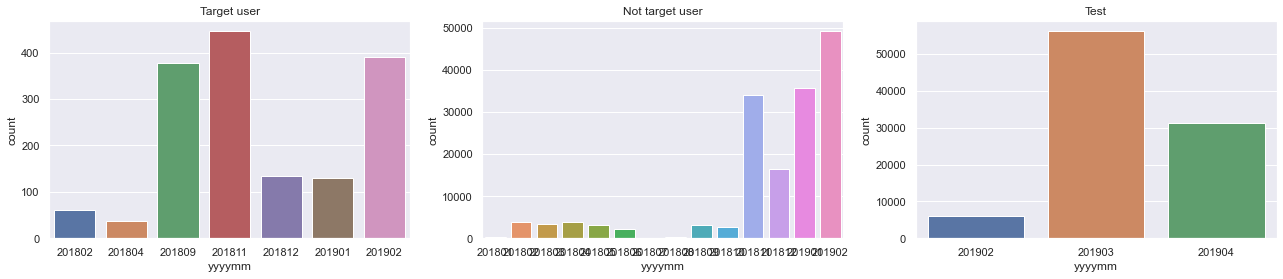

In [ ]:
build_countplot('yyyymm')

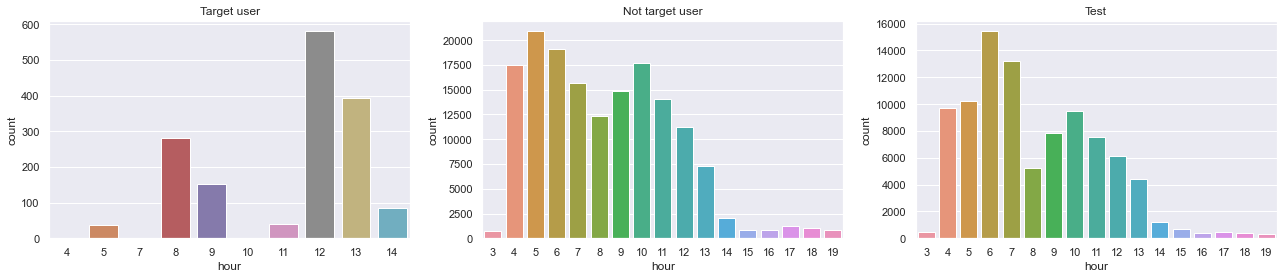

In [ ]:
build_countplot('hour')

We can see that the target usually user browses from 8am to 9am and from 11pm to 14pm. He doesn't browse from 15pm till 3am.

In [ ]:
data['peak'] = data['time1'].apply(lambda ts: ((ts.hour >= 8) & (ts.hour < 10)) | ((ts.hour >= 11) & (ts.hour < 15)) | ts.hour==5).astype(np.int8)
data['not_peak'] = data['time1'].apply(lambda ts: (ts.hour >= 15) | (ts.hour < 4)).astype(np.int8)

Text(0.5, 1.0, 'Target user domains')

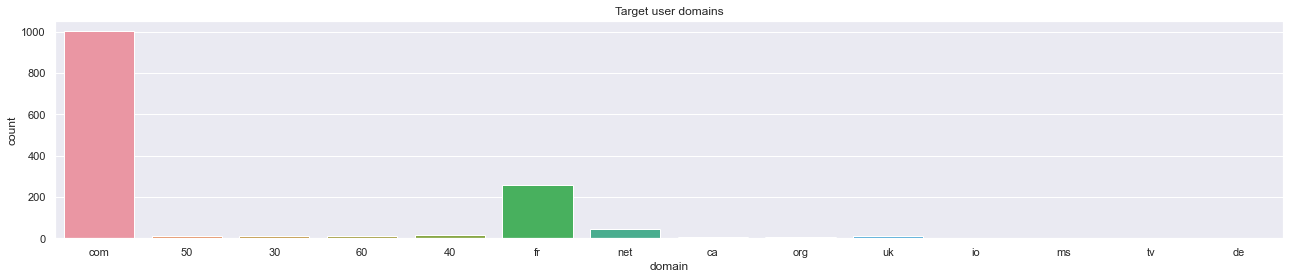

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,4))
sns.countplot(x="domain", data=data[data.target==1][:idx], ax=axes).set_title('Target user domains')

The next feature indicates if the domain is common domain.

In [ ]:
data['common_domain'] = data['domain'].map(lambda x: x in ('com', 'fr', 'net', 'uk', 'org', 'tv')).astype(np.int)

Next we should drop the unnecessary features (and target feature) and scale the numerical features.

In [ ]:
data.drop(times + webpages + ['target', 'id', 'domain'], inplace=True, axis=1)

In [ ]:
features_to_scale = [
    'duration',
    'yyyymm',
    'dayofweek',
    'hour',
]
data[features_to_scale] = StandardScaler().fit_transform(data[features_to_scale])

Here I form train and test datasets.

In [ ]:
X_train = csr_matrix(hstack([words[:idx], data[:idx]]))
X_test = csr_matrix(hstack([words[idx:], data[idx:]]))
y_train = train.target

I use `EasyEnsembleClassifier` as a model with `BalancedRandomForestClassifier` as base estimator since it gave the highest score. `TimeSeriesSplit` is used for crossvalidation since the data is timeseries.

In [ ]:
eec_init = EasyEnsembleClassifier(random_state=0)
time_split = TimeSeriesSplit(n_splits=5)

cv_scores = cross_val_score(eec_init, X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)
data.columns, cv_scores, cv_scores.mean()

(Index(['duration', 'yyyymm', 'dayofweek', 'hour', 'browse_day', 'tue', 'wed',
        'sat', 'peak', 'not_peak', 'common_domain'],
       dtype='object'),
 array([0.81781773, 0.9019539 , 0.83048698, 0.90358728, 0.98159453]),
 0.8870880834522488)

In [ ]:
# Grid Search

eec = EasyEnsembleClassifier()

eec_params = {
    'n_estimators':[30,50,70],
    'base_estimator':[BalancedRandomForestClassifier()],
    'replacement':[False,True]
}

grid = GridSearchCV(eec, param_grid=eec_params, scoring='roc_auc', cv=time_split, refit=True, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best score: ", grid.best_score_)
print("Best parameters", grid.best_params_)

The best parameters from the grid search are: base_estimator=BalancedRandomForestClassifier(), n_estimators=30, replacement=False.

In [ ]:
res = grid.predict_proba(X_test)
res_df = pd.DataFrame({'session_id': test.index, 'target': pd.DataFrame(res)[1]})
res_df.to_csv('out.csv', columns=['session_id', 'target'], index=False)